## Model Algorithm Hyperparameter Tuning:

### Splitting data into Train and Test: Stratified Sampling

In [33]:
# loading data

import pandas as pd
import numpy as np
import joblib

final_data = pd.read_pickle("data_final")

In [34]:
final_data.head(2)

,rating,review,rev_len
0,Positive,without doubt best 2022 movie never seen movie...,222
1,Positive,much better first one,34


In [35]:
# dropping class label column

y = final_data['rating'].values
X = final_data.drop(['rating'], axis=1)
X.head(1)

,review,rev_len
0,without doubt best 2022 movie never seen movie...,222


In [36]:
y = np.where(y == 'Positive',1,0)

In [37]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [38]:
print('Number of Reviews in Train set',X_train.shape[0])
print('Number of Reviews in Test set',X_test.shape[0])

Number of Reviews in Train set 4008
Number of Reviews in Test set 1002


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#encoding comments into bag of words

vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=6500)
vectorizer.fit(X_train['review'].values)

joblib.dump(vectorizer, 'countv.pkl')

X_train_bow = vectorizer.transform(X_train['review'].values)
X_test_bow = vectorizer.transform(X_test['review'].values)

print('Number of features',X_train_bow.shape[1])

Number of features 1071


In [41]:
#encoding comments into if_idf

vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=6500)
vectorizer.fit(X_train['review'].values)

X_train_tfidf = vectorizer.transform(X_train['review'].values)
X_test_tfidf = vectorizer.transform(X_test['review'].values)

print('Number of features',X_train_tfidf.shape[1])

Number of features 1071


In [9]:
# encoding numerical feauture review len

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['rev_len'].values.reshape(-1,1))

X_train_rev_len_norm = normalizer.transform(X_train['rev_len'].values.reshape(-1,1))
X_test_rev_len_norm = normalizer.transform(X_test['rev_len'].values.reshape(-1,1))



In [10]:
# stacking all features horizantally bow_comments

from scipy.sparse import hstack
X_tr = hstack((X_train_bow,X_train_rev_len_norm)).tocsr()
X_te = hstack((X_test_bow,X_test_rev_len_norm)).tocsr()

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

(4008, 1075) (4008,)
(1002, 1075) (1002,)


## Model 1: Decision Tree

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
hyper_param = {'min_samples_split':[5, 10, 100, 500],'max_depth': [1, 3, 10, 30]}
model = GridSearchCV(DecisionTreeClassifier(), hyper_param,scoring='roc_auc', cv=3)
model.fit(X_tr, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             scoring='roc_auc')

In [12]:
model.best_score_

0.7155650596163815

In [13]:
best_RF_model = model.best_estimator_
best_RF_model

DecisionTreeClassifier(max_depth=30, min_samples_split=500)

In [14]:
best_RF_model.fit(X_tr, y_train)
y_train_pred_RF = best_RF_model.predict(X_tr)
y_test_pred_RF = best_RF_model.predict(X_te)

In [15]:
from sklearn.metrics import f1_score

print('train f1 score', f1_score(y_train, y_train_pred_RF))
print('test f1 score', f1_score(y_test, y_test_pred_RF))

train f1 score 0.9824920127795526
test f1 score 0.9806320081549439


In [16]:
# stacking all features horizantally bow_comments

from scipy.sparse import hstack
X_tr_tfidf = hstack((X_train_tfidf,X_train_rev_len_norm)).tocsr()
X_te_tfidf = hstack((X_test_tfidf,X_test_rev_len_norm)).tocsr()

print(X_tr_tfidf.shape, y_train.shape)
print(X_tr_tfidf.shape, y_test.shape)

(4008, 1075) (4008,)
(4008, 1075) (1002,)


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
hyper_param = {'min_samples_split':[5, 10, 100, 500],'max_depth': [1, 3, 10, 30]}
model_tfidf = GridSearchCV(DecisionTreeClassifier(), hyper_param,scoring='roc_auc', cv=3)
model_tfidf.fit(X_tr_tfidf, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             scoring='roc_auc')

In [18]:
best_RF_model_tfidf = model_tfidf.best_estimator_
best_RF_model_tfidf

DecisionTreeClassifier(max_depth=30, min_samples_split=100)

In [19]:
best_RF_model.fit(X_tr, y_train)

y_train_pred_RF_tfidf = best_RF_model_tfidf.predict(X_tr_tfidf)
y_test_pred_RF_tfidf = best_RF_model_tfidf.predict(X_te_tfidf)

In [20]:
from sklearn.metrics import f1_score

print('train f1 score', f1_score(y_train, y_train_pred_RF_tfidf))
print('test f1 score', f1_score(y_test, y_test_pred_RF_tfidf))

train f1 score 0.9849556384209849
test f1 score 0.9779374037968189


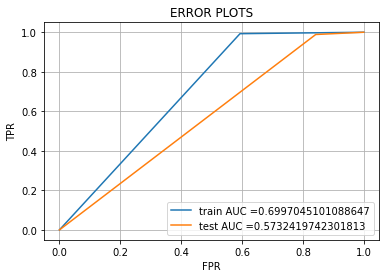

In [21]:
# training model for best value of 0.05

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_RF_tfidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_RF_tfidf)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Model 2: Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
hyper_param = {'min_samples_split':[5, 10, 100, 500],'max_depth': [1, 3, 10, 30],'n_estimators':[25,50,75,100]}
model_RF = GridSearchCV(RandomForestClassifier(), hyper_param,scoring='roc_auc', cv=3)
model_RF.fit(X_tr, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500],
                         'n_estimators': [25, 50, 75, 100]},
             scoring='roc_auc')

In [23]:
RF_model = model_RF.best_estimator_
RF_model

RandomForestClassifier(max_depth=10, min_samples_split=5)

In [24]:
RF_model.fit(X_tr, y_train)
joblib.dump(RF_model, 'model.pkl')
y_train_pred_RF_ = RF_model.predict(X_tr)
y_test_pred_RF_ = RF_model.predict(X_te)

In [25]:
from sklearn.metrics import f1_score

print('train f1 score', f1_score(y_train, y_train_pred_RF_))
print('test f1 score', f1_score(y_test, y_test_pred_RF_))

train f1 score 0.9818043008016287
test f1 score 0.9806714140386571


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
hyper_param = {'min_samples_split':[5, 10, 100, 500],'max_depth': [1, 3, 10, 30],'n_estimators':[25,50,75,100]}
model_RF_tfidf = GridSearchCV(RandomForestClassifier(), hyper_param,scoring='roc_auc', cv=3)
model_RF_tfidf.fit(X_tr_tfidf, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500],
                         'n_estimators': [25, 50, 75, 100]},
             scoring='roc_auc')

In [27]:
RF_model_tfidf = model_RF_tfidf.best_estimator_
RF_model_tfidf

RandomForestClassifier(max_depth=30, min_samples_split=500)

In [28]:
RF_model_tfidf.fit(X_tr_tfidf, y_train)
y_train_pred_RF_ifidf = RF_model.predict(X_tr_tfidf)
y_test_pred_RF_tfidf = RF_model.predict(X_te_tfidf)

In [29]:
from sklearn.metrics import f1_score

print('train f1 score', f1_score(y_train, y_train_pred_RF_ifidf))
print('test f1 score', f1_score(y_test, y_test_pred_RF_tfidf))

train f1 score 0.9809305873379099
test f1 score 0.9806714140386571


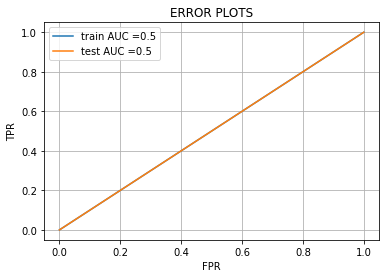

In [30]:
# training model for best value of 0.05

from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred_RF_ifidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred_RF_tfidf)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Summary

In [31]:
pip install PrettyTable

Note: you may need to restart the kernel to use updated packages.


In [32]:
# tabulate results
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "f1_score"]
x.add_rows(
    [
        ["BOW", 'DecisionTreeClassifier', f1_score(y_test, y_test_pred_RF)],
        ["TF_IDF",'DecisionTreeClassifier',f1_score(y_test, y_test_pred_RF_tfidf)],
        ["BOW", 'RandomForestClassifier', f1_score(y_test, y_test_pred_RF_)],
        ["TF_IDF",'RandomForestClassifier',f1_score(y_test, y_test_pred_RF_tfidf)],
    ]
)

print(x)

+------------+------------------------+--------------------+
| Vectorizer |         Model          |      f1_score      |
+------------+------------------------+--------------------+
|    BOW     | DecisionTreeClassifier | 0.9806320081549439 |
|   TF_IDF   | DecisionTreeClassifier | 0.9806714140386571 |
|    BOW     | RandomForestClassifier | 0.9806714140386571 |
|   TF_IDF   | RandomForestClassifier | 0.9806714140386571 |
+------------+------------------------+--------------------+
